# The material presented in this jupyter notebook is part of the "ECE 685D: Introduction to Deep Learning" course offered at Duke University.

# Session: Fall 2021

# Part 8b: Variational Autoencoders (VAEs)

### Summary:

A VAE uses two neural networks,

* Encoder ($q_{\phi}(z|x)$): Encodes X into Z. To get Z, we do the following
    * Encoder outputs $\mu$ and log-variance (instead of $\sigma$).
    * Sample $z \sim Normal(\mu, \sigma^2)$ using reparameterization trick.
    
* Decoder ($p_{\theta}(x|z)$): Decode from Z to X.

To train a VAE, we maximize the Evidence Lower Bound (ELBO):

$$ELBO (x) = \mathbb{E}_{q_{\phi}(z|x)}\log(p_{\theta}(x|z)) - \text{KL}[q_{\phi}(z|x) || p(z)]$$

### Import Modules

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import seaborn as sns

### Prepare Dataloader

In [136]:
batch_size = 128

train_set,test_set,train_loader,test_loader = {},{},{},{}
transform = transforms.Compose(
    [transforms.ToTensor()])

train_set['kmnist'] = torchvision.datasets.KMNIST(root='../data', train=True, download=False, transform=transform)
train_set['kmnist_d'] = torchvision.datasets.KMNIST(root='../data', train=True, download=False, transform=transform)
test_set['kmnist'] = torchvision.datasets.KMNIST(root='../data', train=False, download=False, transform=transform)
test_set['kmnist_d'] = torchvision.datasets.KMNIST(root='../data', train=False, download=False, transform=transform)
train_loader['kmnist'] = torch.utils.data.DataLoader(train_set['kmnist'], batch_size=batch_size, shuffle=False, num_workers=0)
train_loader['kmnist_d'] = torch.utils.data.DataLoader(train_set['kmnist_d'], batch_size=batch_size, shuffle=False, num_workers=0)
test_loader['kmnist'] = torch.utils.data.DataLoader(test_set['kmnist'], batch_size=batch_size, shuffle=False, num_workers=0)
test_loader['kmnist_d'] = torch.utils.data.DataLoader(test_set['kmnist_d'], batch_size=batch_size, shuffle=False, num_workers=0)

device = 'cpu'

### Randomly change some pixels to black

In [140]:
def add_black(size,dataset):
    for i in range(dataset.data.shape[0]):
        horizon_point = np.random.randint(0,28-size)
        dataset.data[i, horizon_point:horizon_point+size, horizon_point:horizon_point+size] = 0
    return dataset

In [141]:
train_set['kmnist_d'] = add_black(size=15, dataset=train_set['kmnist_d'])
test_set['kmnist_d'] = add_black(size=15, dataset=test_set['kmnist_d'])

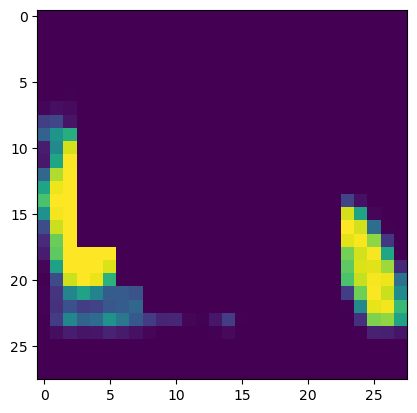

In [143]:
plt.imshow(test_set['kmnist_d'].data[21])

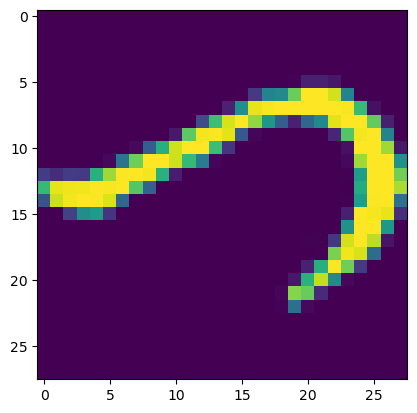

In [126]:
plt.imshow(train_set['kmnist'].data[21])

### This is our VAE model

In [127]:
class VAE(nn.Module):
    def __init__(self, n_in, n_hid, z_dim):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(n_in, n_hid)
        self.fc21 = nn.Linear(n_hid, z_dim)
        self.fc22 = nn.Linear(n_hid, z_dim)
        self.fc3 = nn.Linear(z_dim, n_hid)
        self.fc4 = nn.Linear(n_hid, n_in)

    def encode(self, x):
        """Encoder forward pass.
        
        Args:
            x: Input image
            
        Returns:
            mu: self.fc21(h1)
            logvar: self.fc22(h1)
        """
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        """Implements: z = mu + epsilon*stdev.
            
        Args: 
            mu: mean
            logvar: log of variance
        
        Return:
            z: sample from Normal(mu, var).
            
            Epsilon is sampled from standard normal distribution. 
            \epsilon \sim Normal(0, 1)
        """
        
        stdev = torch.exp(0.5*logvar)
        eps = torch.randn_like(stdev)
        return mu + eps*stdev

    def decode(self, z):
        """Decoder forward pass.
        
        Args:
            z: Batch of latent representations.
        
        Returns: 
            x_recon: Image probabilities.
        """
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        """Implements forward pass of VAE.
        
        Args:
            x: Batch of input images.
        
        Returns:
            x_recon: Batch of reconstructed images.
            mu: Batch of mean vectors
            logvar: Batch of log-variance vectors
        """
        
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_function(recon_x, x, mu, logvar):
    """Computes the loss = -ELBO = Negative Log-Likelihood + KL Divergence.
    
    Args: 
        recon_x: Decoder output.
        x: Ground truth.
        mu: Mean of Z
        logvar: Log-Variance of Z
        
        p(z) here is the standard normal distribution with mean 0 and identity covariance.
    """
    
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum') # BCE = -Negative Log-likelihood
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # KL Divergence b/w q_\phi(z|x) || p(z)
    return BCE + KLD

In [144]:
def train(model, device, train_loader, train_loader_undam, optimizer, epoch):
    train_loss = 0
    model.train()
    for ((x, target), (x_undam, target_undam)) in zip(train_loader, train_loader_undam):
        
        x = x.view(x.size(0),-1)
        x = x.to(device)
        x_undam = x_undam.view(x_undam.size(0),-1)
        x_undam = x_undam.to(device)
        
        optimizer.zero_grad()
        output, mu, logvar = model(x)
        loss = loss_function(output, x_undam, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    train_loss = train_loss/len(train_loader)
    print('Epoch ({}) Train Loss: {:.4f}'.format(epoch, train_loss))
    
    return train_loss

def test(model, device, test_loader, test_loader_undam, optimizer, epoch):
    test_loss = 0
    model.eval()
    with torch.no_grad():
        for ((x, target), (x_undam, target_undam)) in zip(test_loader, test_loader_undam):
            
            x = x.view(x.size(0),-1)
            x = x.to(device)
            x_undam = x_undam.view(x_undam.size(0),-1)
            x_undam = x_undam.to(device)
            
            output, mu, logvar = model(x)
            loss = loss_function(output, x_undam, mu, logvar)
            test_loss += loss.item() # sum up batch loss
            
    test_loss = test_loss/len(test_loader)
    print('Test({}): Loss: {:.4f}'.format(epoch, test_loss))
    
    return test_loss

In [129]:
def make_optimizer(optimizer_name, model, **kwargs):
    if optimizer_name=='Adam':
        optimizer = optim.Adam(model.parameters(),lr=kwargs['lr'])
    elif optimizer_name=='SGD':
        optimizer = optim.SGD(model.parameters(),lr=kwargs['lr'],momentum=kwargs['momentum'], weight_decay=kwargs['weight_decay'])
    else:
        raise ValueError('Not valid optimizer name')
    return optimizer

In [130]:
seed = 1
data_name = 'kmnist'
optimizer_name = 'Adam'

num_epochs = 10
lr = 0.001
n_in = 28*28
n_hid = 400
z_dim = 20

#device = torch.device(device)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [131]:
vae = VAE(n_in, n_hid, z_dim)
# train(model, device, train_loader, train_loader_undam, optimizer, epoch):
optimizer = make_optimizer(optimizer_name, vae, lr=lr)
device = None
for epoch in range(1, num_epochs + 1):
    train(vae, device, train_loader['kmnist_d'], train_loader['kmnist'], optimizer, epoch)


Epoch (1) Train Loss: 37477.8575
Epoch (2) Train Loss: 31873.3513
Epoch (3) Train Loss: 30633.9612
Epoch (4) Train Loss: 30059.4863
Epoch (5) Train Loss: 29681.6638
Epoch (6) Train Loss: 29418.4926
Epoch (7) Train Loss: 29213.5602
Epoch (8) Train Loss: 29058.1299
Epoch (9) Train Loss: 28920.0717
Epoch (10) Train Loss: 28803.9012


In [145]:
test(vae, device, test_loader['kmnist_d'], test_loader['kmnist'], optimizer, epoch)

Test(10): Loss: 37478.8481


37478.84811980815

In [132]:
def show(img1, img2):
    npimg1 = img1.cpu().numpy()
    npimg2 = img2.cpu().numpy()
    
    fig, axes = plt.subplots(1,2, figsize=(20,10))
    axes[0].imshow(np.transpose(npimg1, (1,2,0)), interpolation='nearest')
    axes[1].imshow(np.transpose(npimg2, (1,2,0)), interpolation='nearest')
    fig.show()

In [133]:
data,_ = next(iter(train_loader['kmnist_d']))
data = data[:128]
data_size = data.size()
data = data.view(data.size(0),-1).to(device)
output, _, _ = vae(data)
output = output.detach()

/var/folders/m9/yqtgx4_d7f10f_9fsz9b1bpr0000gn/T/ipykernel_64295/2568326077.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


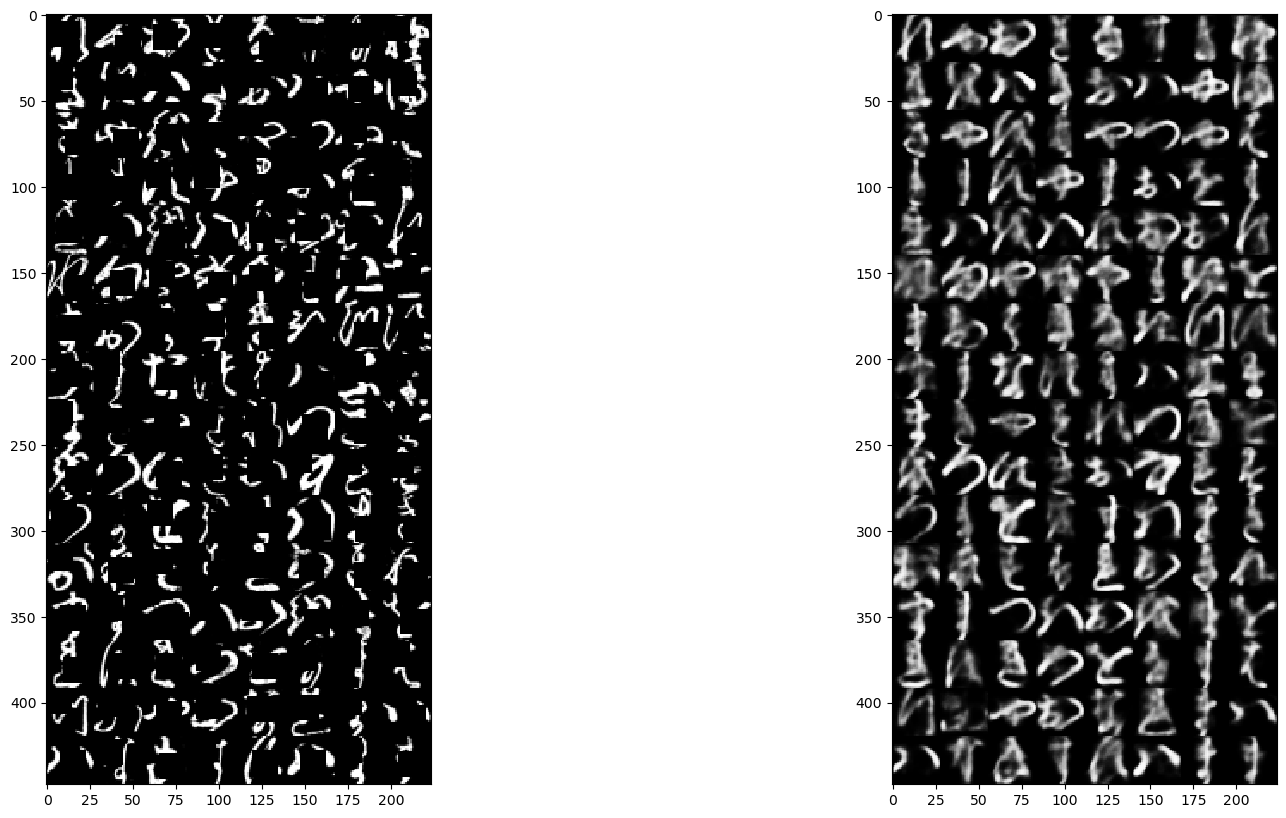

In [135]:
### reconstruction on train set
show(make_grid(data.reshape(data_size), padding=0), make_grid(output.reshape(data_size), padding=0))

In [146]:
data,_ = next(iter(test_loader['kmnist_d']))
data = data[:128]
data_size = data.size()
data = data.view(data.size(0),-1).to(device)
output, _, _ = vae(data)
output = output.detach()

/var/folders/m9/yqtgx4_d7f10f_9fsz9b1bpr0000gn/T/ipykernel_64295/2568326077.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


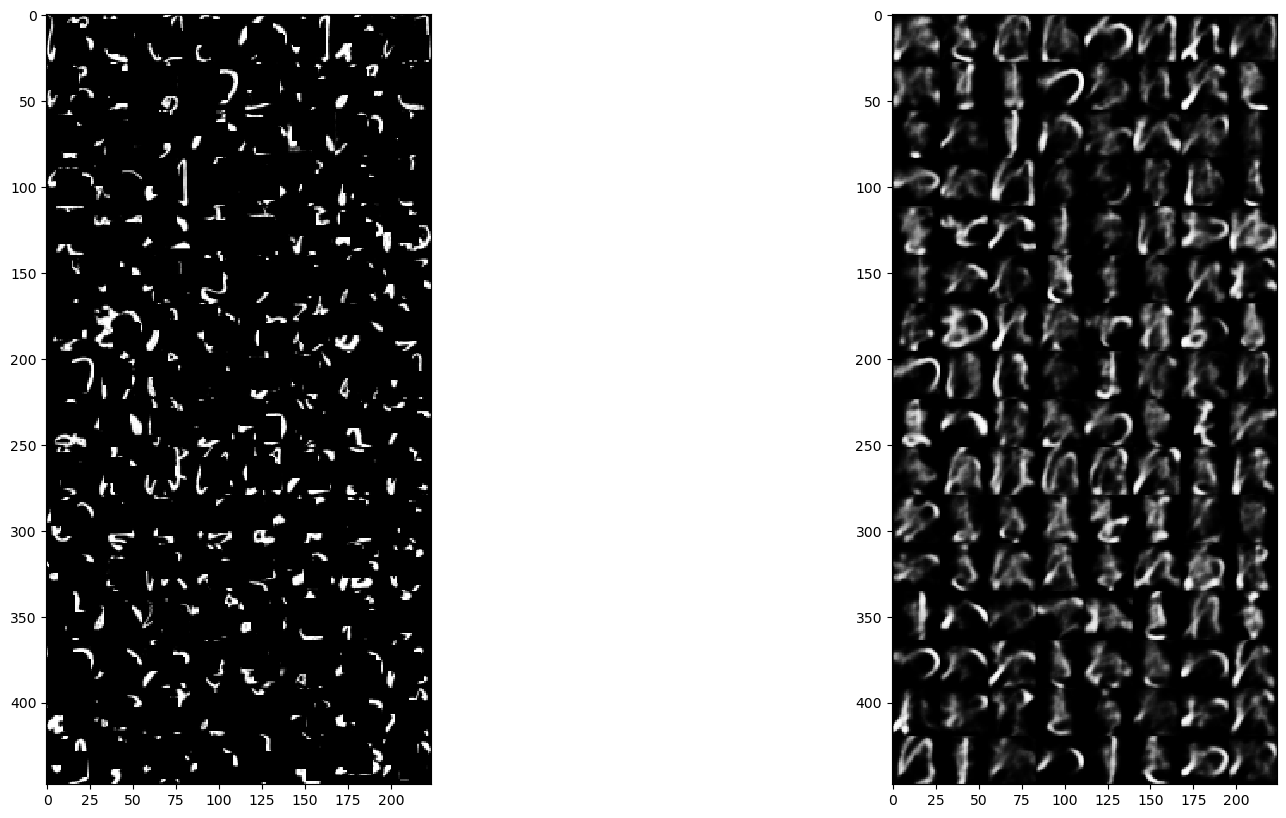

In [147]:
### reconstruction on test set
show(make_grid(data.reshape(data_size), padding=0), make_grid(output.reshape(data_size), padding=0))

### This is our C-VAE Model

We will add the label in as a conditional variable c. 

In [85]:
class C_VAE(nn.Module):
    def __init__(self, n_in, n_hid, z_dim):
        super(C_VAE, self).__init__()

        # self.fc1 = nn.Linear(n_in, n_hid)
        # self.fc21 = nn.Linear(n_hid, z_dim)
        # self.fc22 = nn.Linear(n_hid, z_dim)
        # self.fc3 = nn.Linear(z_dim+10, n_hid)
        # self.fc4 = nn.Linear(n_hid, n_in)
        self.fc1 = nn.Linear(n_in, n_hid)
        self.fc2 = nn.Linear(n_hid, n_hid)
        self.fc31 = nn.Linear(n_hid, z_dim)
        self.fc32 = nn.Linear(n_hid, z_dim)
        self.fc4 = nn.Linear(z_dim+10, n_hid)
        self.fc5 = nn.Linear(n_hid, n_in)

        
    def one_hot(self, label):
        one_hot = F.one_hot(label)
        return one_hot.to(torch.float32)
    
    def encode(self, x, label):
        """Encoder forward pass.
        
        Args:
            x: Input image
            
        Returns:
            mu: self.fc21(h1)
            logvar: self.fc22(h1)
        """
        label = self.one_hot(label)
        concat = torch.cat((x, label), 1)
        h1 = F.relu(self.fc1(concat))
        h2 = F.relu(self.fc2(h1))
        return self.fc31(h2), self.fc32(h2)

    def reparameterize(self, mu, logvar):
        """Implements: z = mu + epsilon*stdev.
            
        Args: 
            mu: mean
            logvar: log of variance
        
        Return:
            z: sample from Normal(mu, var).
            
            Epsilon is sampled from standard normal distribution. 
            \epsilon \sim Normal(0, 1)
        """
        
        stdev = torch.exp(0.5*logvar)
        eps = torch.randn_like(stdev)
        return mu + eps*stdev

    def decode(self, z, label):
        """Decoder forward pass.
        
        Args:
            z: Batch of latent representations.
        
        Returns: 
            x_recon: Image probabilities.
        """
        label = self.one_hot(label)
        concat = torch.cat((z, label), 1)
        h3 = F.relu(self.fc4(concat))
        return torch.sigmoid(self.fc5(h3))

    def forward(self, x, label):
        """Implements forward pass of VAE.
        
        Args:
            x: Batch of input images.
        
        Returns:
            x_recon: Batch of reconstructed images.
            mu: Batch of mean vectors
            logvar: Batch of log-variance vectors
        """
        
        mu, logvar = self.encode(x, label)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, label), mu, logvar

def loss_function(recon_x, x, mu, logvar):
    """Computes the loss = -ELBO = Negative Log-Likelihood + KL Divergence.
    
    Args: 
        recon_x: Decoder output.
        x: Ground truth.
        mu: Mean of Z
        logvar: Log-Variance of Z
        
        p(z) here is the standard normal distribution with mean 0 and identity covariance.
    """
    
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum') # BCE = -Negative Log-likelihood
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # KL Divergence b/w q_\phi(z|x) || p(z)
    return BCE + KLD

In [86]:
def train(model, train_loader, optimizer, epoch):
    train_loss = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.view(data.size(0),-1)
         
        optimizer.zero_grad()
        output, mu, logvar = model(data, target)
        
        label_oh = model.one_hot(target)
        concat = torch.cat((data, label_oh), 1)
        
        loss = loss_function(output, concat, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if batch_idx % (len(train_loader)//2) == 0:
            print('Train({})[{:.0f}%]: Loss: {:.4f}'.format(
                epoch, 100. * batch_idx / len(train_loader), train_loss/(batch_idx+1)))
    return train_loss

def test(model, test_loader, epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.view(data.size(0),-1)
            output, mu, logvar = model(data, target)
            
            label_oh = model.one_hot(target)
            concat = torch.cat((data, label_oh), 1)
            
            loss = loss_function(output, concat, mu, logvar)
            test_loss += loss.item() # sum up batch loss
    test_loss = (test_loss*batch_size)/len(test_loader.dataset)
    print('Test({}): Loss: {:.4f}'.format(
        epoch, test_loss))
    return test_loss

In [87]:
def make_optimizer(optimizer_name, model, **kwargs):
    if optimizer_name=='Adam':
        optimizer = optim.Adam(model.parameters(),lr=kwargs['lr'])
    elif optimizer_name=='SGD':
        optimizer = optim.SGD(model.parameters(),lr=kwargs['lr'],momentum=kwargs['momentum'], weight_decay=kwargs['weight_decay'])
    else:
        raise ValueError('Not valid optimizer name')
    return optimizer

In [88]:
seed = 1
data_name = 'mnist'
optimizer_name = 'Adam'

num_epochs = 10
lr = 0.001
n_in = 28*28+10
n_hid = 400
z_dim = 20

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [89]:
c_vae = C_VAE(n_in, n_hid, z_dim)

optimizer = make_optimizer(optimizer_name, c_vae, lr=lr)

for epoch in range(1, num_epochs + 1):
    train(c_vae, train_loader[data_name], optimizer, epoch)

test(c_vae, test_loader[data_name], epoch)

Train(1)[0%]: Loss: 70918.1797
Train(1)[50%]: Loss: 39305.9291
Train(1)[100%]: Loss: 36541.0983
Train(2)[0%]: Loss: 32906.8203
Train(2)[50%]: Loss: 32736.0290
Train(2)[100%]: Loss: 32510.4096
Train(3)[0%]: Loss: 31658.5215
Train(3)[50%]: Loss: 31784.2288
Train(3)[100%]: Loss: 31745.7128
Train(4)[0%]: Loss: 31359.3418
Train(4)[50%]: Loss: 31461.7957
Train(4)[100%]: Loss: 31372.3363
Train(5)[0%]: Loss: 31541.6562
Train(5)[50%]: Loss: 31192.0206
Train(5)[100%]: Loss: 31138.8846
Train(6)[0%]: Loss: 30809.4062
Train(6)[50%]: Loss: 30933.9825
Train(6)[100%]: Loss: 30980.4287
Train(7)[0%]: Loss: 30844.9492
Train(7)[50%]: Loss: 30883.8221
Train(7)[100%]: Loss: 30852.4862
Train(8)[0%]: Loss: 29795.0527
Train(8)[50%]: Loss: 30809.3243
Train(8)[100%]: Loss: 30757.9613
Train(9)[0%]: Loss: 31149.2891
Train(9)[50%]: Loss: 30618.0557
Train(9)[100%]: Loss: 30668.5383
Train(10)[0%]: Loss: 29216.8184
Train(10)[50%]: Loss: 30630.5518
Train(10)[100%]: Loss: 30605.7167
Test(10): Loss: 30848.7002


30848.700234375

In [103]:
data,label = next(iter(test_loader[data_name]))
data = data[:128]
data_size = data.size()
data = data.view(data.size(0),-1)
output, _, _ = c_vae(data,label)
output = output.detach()

/var/folders/m9/yqtgx4_d7f10f_9fsz9b1bpr0000gn/T/ipykernel_4954/2568326077.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


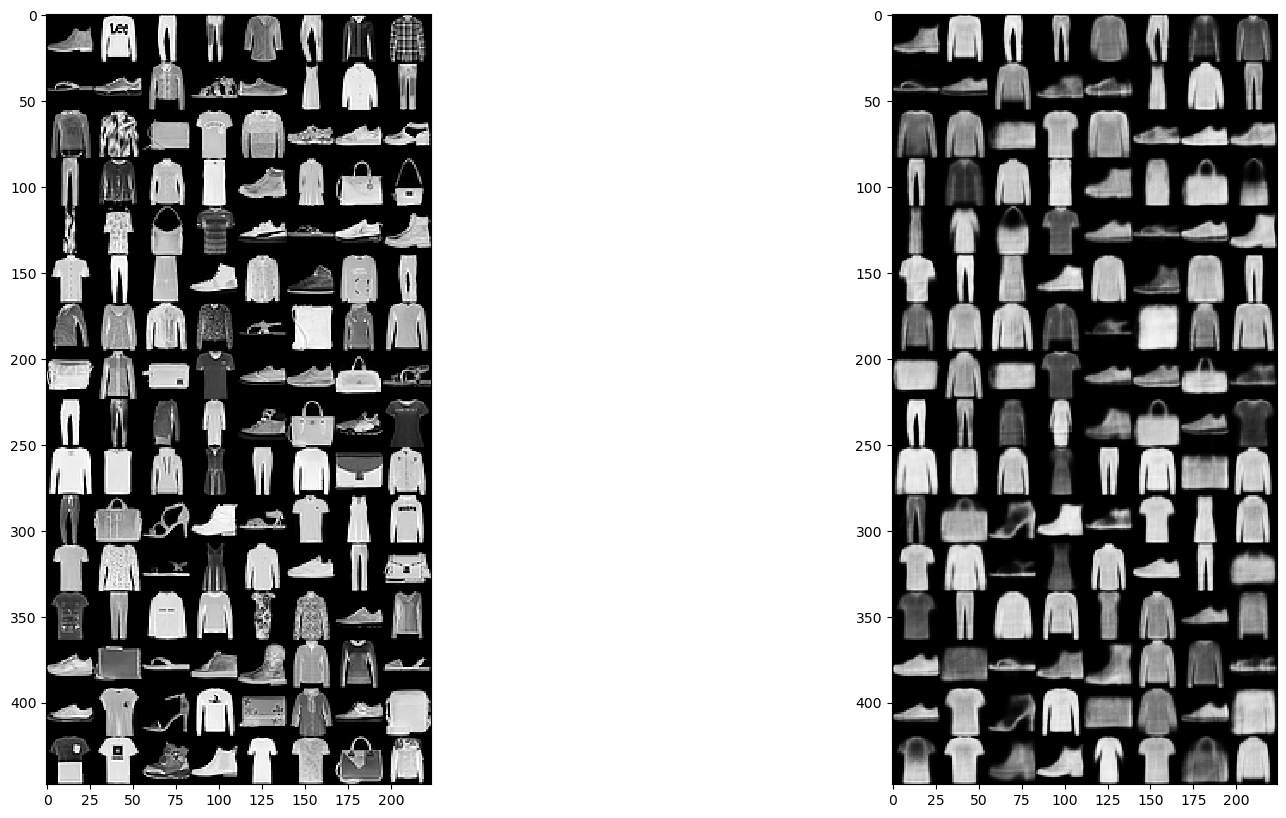

In [107]:
show(make_grid(data.reshape(data_size), padding=0),make_grid(output[:,0:784].reshape(data_size), padding=0))